In [1]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


import findspark
findspark.init()
findspark.find()

import pyspark

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 229 kB in 2s (101 kB/s)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
45 packages can be upgraded. Run 'apt list --upgradable' to see them.
tar: spark-3.2.1-bin-hadoop3.2.tgz: Cannot open:

In [40]:
import pyspark
import pyspark.sql.functions as F
import numpy as np
from pyspark.sql import SparkSession
import numpy as np
from datetime import datetime, timedelta
from pyspark.sql.window import Window
import numpy as np
import math
import pandas as pd
import subprocess
from google.colab import drive
import plotly.express as px
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import to_date, col
from pyspark.sql.functions import lag
from pyspark.sql.window import Window
from pyspark.ml import Pipeline

In [41]:
spark = SparkSession.builder \
    .appName("Amazon Stock Prediction") \
    .getOrCreate()

In [42]:
spark

In [49]:
path = "datos_amazon.csv"
df = spark.read.csv(path, header=True, inferSchema=True)
for c in df.columns:
    df = df.withColumnRenamed(c, c.replace('_u1.', ''))


In [87]:
df = df.withColumn("date", to_date(col("date"), "yyyy-MM-dd"))
windowSpec = Window.orderBy("date")
df = df.withColumn("close_lag_1", lag("close", 8).over(windowSpec))
df = df.withColumn("close_lag_2", lag("close", 9).over(windowSpec))
df = df.withColumn("close_lag_3", lag("close", 10).over(windowSpec))
df = df.withColumn("close_lag_4", lag("close", 11).over(windowSpec))
df = df.withColumn("close_lag_5", lag("close", 12).over(windowSpec))
df = df.withColumn("close_lag_6", lag("close", 13).over(windowSpec))
df = df.withColumn("close_lag_7", lag("close", 14).over(windowSpec))

df = df.withColumn("close_lag-1", lag("close", -1).over(windowSpec))

In [88]:
assembler = VectorAssembler(inputCols=["close_lag_1", "close_lag_2", "close_lag_3", "close_lag_4", "close_lag_5", "close_lag_6", "close_lag_7", "open", "high", "low", "volume"], outputCol="features", handleInvalid="skip")


In [90]:
# scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)

lr = LinearRegression(featuresCol="features", labelCol="close_lag-1")

pipeline = Pipeline(stages=[assembler, lr])

In [91]:
train_data = df.filter(col("date") <= "2023-12-31")
validation_data = df.filter((col("date") >= "2024-01-01") & (col("date") <= "2024-01-10"))

In [92]:
model = pipeline.fit(train_data)

In [93]:
# Prediction on validation data
validation_predictions = model.transform(validation_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="close_lag-1", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(validation_predictions)
mae = evaluator.evaluate(validation_predictions, {evaluator.metricName: "mae"})
r2 = evaluator.evaluate(validation_predictions, {evaluator.metricName: "r2"})

print(f"Validation RMSE: {rmse}")
print(f"Validation MAE: {mae}")
print(f"Validation R^2: {r2}")


Validation RMSE: 2.720815031871148
Validation MAE: 2.2791022010712987
Validation R^2: 0.4665069089557893


In [94]:
result_pdf = validation_predictions.select("date", "prediction", "close_lag-1").toPandas()

In [95]:
result_pdf.sort_values('date', inplace=True)


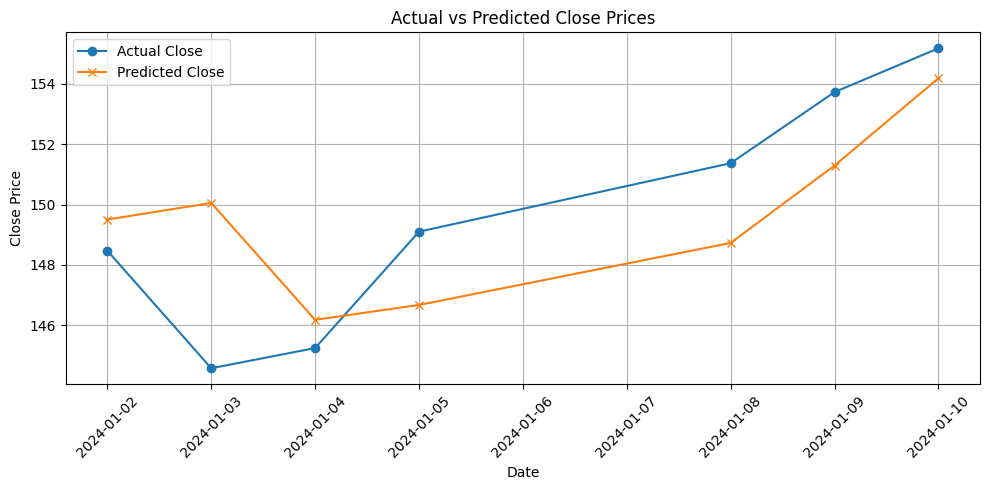

In [96]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(result_pdf['date'], result_pdf['close_lag-1'], label='Actual Close', marker='o')
plt.plot(result_pdf['date'], result_pdf['prediction'], label='Predicted Close', marker='x')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
